# Lecture 1.4: Introduction to Linear Regression

## Outline

* What is linear regression?
* How to estimate linear regression coefficients?
* How to interpret the regression model?

In statistics, ** linear regression ** is an approach for modeling the relationship between a scalar dependent variable (or response variable) $y$ and one or more explanatory variables (or independent variables) denoted $X$. ([Wikipedia](https://en.wikipedia.org/wiki/Linear_regression))

* ** Simple linear regresssion **: only one explanatory variable
* ** Multiple linear regression **: more than one explanatory variable

## Let's start with an example

Suppose we want to predict the fuel efficiency of a car (mpg) using its weight.

We will use the data set `cars` from yesterday which contains variables `mpg` and `weight`.

In [1]:
%pylab inline
import pandas as pd
import yaml

Populating the interactive namespace from numpy and matplotlib


From now on we will use [SQLAlchemy](http://www.sqlalchemy.org/) directly rather than relying on the `ipython-sql` magic:

In [2]:
from sqlalchemy import create_engine

pg_creds = yaml.load(open('../../pg_creds.yaml'))['student']

engine = create_engine('postgresql://{user}:{password}@{host}:{port}/{dbname}'.format(**pg_creds))

In [3]:
cars = pd.read_sql_table('cars', engine)

## Linear Regression

We want to model the relationship between `mpg` and `weight` with a straight line.

First, let's do some EDA..

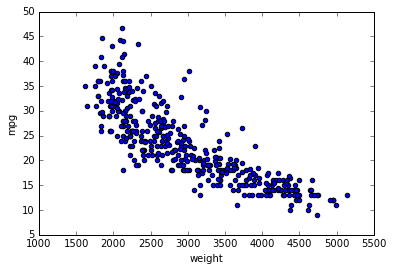

In [4]:
# Plot the variables of interest first
cars.plot('weight', 'mpg', kind='scatter');

* Linear regression is just the fancy term for finding the line of best fit. If I was going to eyeball it from this data, I would draw the line from (1000,40) through (5500,5)

* In other words, we are looking for the slope and intercept that defines a line that fits the data as well as possible

* 'As well as possible' often means that we are trying to minimize the sum of squared residuals (more on this later)

In [5]:
# Make a guess at the line of best fit
first_point = [1000,45]
second_point = [5500, 0]

# Solve 
def get_line_equation(p1, p2):
    """
    Solve the system of equations:
    y1 = m*x1 + b
    y2 = m*x2 + b
    
    Input:
    p1: first point [x1, y1]
    p2: second point [x2, y2]
    
    returns: slope, intercept
    """
    X = [[p1[0], 1], [p2[0], 1]]
    y = [[p1[1]], [p2[1]]]
    soln = np.linalg.solve(X,y)
    return  soln[0][0], soln[1][0]

slope, intercept = get_line_equation(first_point, second_point)

(1000, 5500)

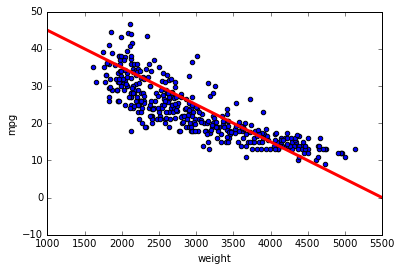

In [6]:
# Plot the line along with the data
ax = cars.plot('weight', 'mpg', kind='scatter')
xx = np.linspace(1000, 5500, 100)
ax.plot(xx, xx * slope + intercept, color='red', lw=3)
ax.set_xlim([1000,5500])

Model assumption: y and X are linearly related
* $y_i = \beta_0 + \beta_1 x_i + \varepsilon_i$, $i = 1, \dots, n$ (simple linear regression)  
* $y_i = \beta_0 + \beta_1 x_{i1} + \cdots + \beta_p x_{ip} + \varepsilon_i$ 
    or $y = X \beta + \varepsilon$ (multiple linear regression)   
    
$y = \begin{bmatrix} y_1 \\y_2 \\ \vdots \\ y_n \end{bmatrix}$, 
    $X = \begin{bmatrix} 1 & x_{11} & \dots & x_{1p} \\ 1 & x_{21} & \dots & x_{2p} \\ \vdots & \vdots & \ddots & \vdots \\ 1 & x_{n1} & \dots & x_{np} \end{bmatrix}$, 
    $\beta = \begin{bmatrix} \beta_0 \\ \beta_1 \\ \vdots \\ \beta_p \end{bmatrix}$, 
    $\varepsilon = \begin{bmatrix} \varepsilon_1 \\ \varepsilon_2 \\ \vdots \\ \varepsilon_n \end{bmatrix}$  

* $n$: sample size, $p$: number of explanatory variables / predictors  

* No matter how statistically significant the regression result is, it ** cannot prove causality **

* The points that fall on the fitted straight line are called the ** fitted values **, $\hat{y}$
* $\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_i$, where $\hat{\beta}_0$ and $\hat{\beta}_1$ are the estimated intercept and slope of the line
* A ** residual ** is the difference between an observed value and the fitted value provided by a model, $e_i = y_i - \hat{y}_i$
* Data = Fit + Residual
* ** Ordinary least squares (OLS) ** is the simplest and most common way to estimate the intercept and the slope, and it does so by minimizing the sum of squared residuals

## Ordinary Least Squares

* Minimizes $\sum_{i=1}^n e_i^2$ ([visual explanation](http://setosa.io/ev/ordinary-least-squares-regression/))


* In the simple linear regression case,

    $\hat{\beta}_1 = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2}$, or
    
    $\hat{\beta}_1 = r_{xy} \frac{s_y}{s_x}$, where $r_{xy}$ is the correlation between $x$ and $y$, $s_x$ and $s_y$ are the standard deviations of $x$ and $y$

    $\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}$

* For multiple linear regression, $\hat{\beta}$ has the following form,


$ \hat{\beta} = (X^TX)^{-1}X^Ty $

Ordinary least squares is implemented in the `statsmodels` package. The advantage of this package is that we also have access to a number of *regression diagnostics* (to be covered later in the course). 

In [7]:
import statsmodels.api as sm

In [8]:
# Choose the predictor and add a constant term
# (allow for an intercept)
X = cars[['weight']]
X = sm.add_constant(X)
X.head()

,const,weight
0,1,3504.0
1,1,3693.0
2,1,3436.0
3,1,3433.0
4,1,3449.0


In [9]:
y = cars.mpg
y.head()

0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64

In [10]:
# Create an OLS model
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     888.9
Date:                Thu, 25 Aug 2016   Prob (F-statistic):          2.97e-103
Time:                        17:34:28   Log-Likelihood:                -1148.4
No. Observations:                 398   AIC:                             2301.
Df Residuals:                     396   BIC:                             2309.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         46.3174      0.795     58.243      0.000        44.754    47.881
weight        -0.0077      0.000    -29.814      0.000        -0.008    -0.007
==============================================================================
Omnibus:                       40.423   Durbin-Watson:                   0.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.695
Skew:                           0.713   Prob(JB):                     4.89e-13
Kurtosis:                       4.176   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## $R^2$

Some definitions:
* Total sum of squares (** SST **): $\sum_{i=1}^n (y_i - \bar{y})^2$


* Regression sum of squares (** SSR **): $\sum_{i=1}^n (\hat{y}_i - \bar{y})^2$


* Residual sum of squares (** SSE **): $\sum_{i=1}^n e_i^2$  



SST = SSR + SSE


$R^2 = \frac{SSR}{SST}$


## Model Interpretation

* **Intercept** - The mean value for $y$ when $x=0$

* **slope** - For each unit increase in $x$, the expected increase/decrease in $y$ (in the case of multiple linear regression, we need to add "holding all other explanatory variables constant", since there are more than one exaplanatory variable in the model.)

* $\textbf{R}^2$ - Proportion of the variation in $y$ that is explained by the model. Measured on a scale from 0 (bad) to 1 (good)

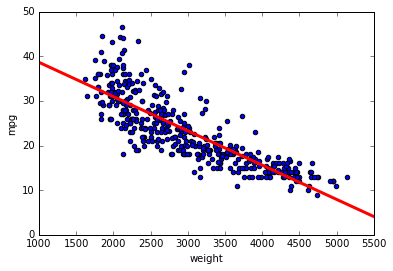

In [11]:
# Plot the line along with the data
intercept, slope = results.params
ax = cars.plot('weight', 'mpg', kind='scatter')
xx = np.linspace(1000, 5500, 100)
ax.plot(xx, xx*slope + intercept, color='red', lw=3)
ax.set_xlim([1000,5500]);

In [12]:
from seaborn import lmplot

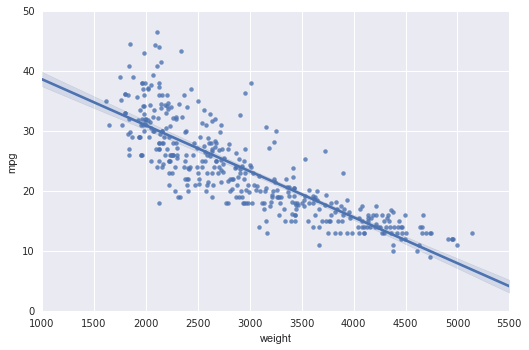

In [13]:
lmplot('weight', 'mpg', data=cars, aspect=1.5);